In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from joblib import dump, load
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
from scipy.stats import kurtosis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv('data.csv').drop(['Unnamed: 0'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, var_366 to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
# Train and test set... Do not touch the test set until final testing of your models
X_train, X_test, Y_train, Y_test = train_test_split(
    df.drop(labels=['TARGET'], axis=1),
    df['TARGET'], test_size=0.3,random_state=42)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

## Analyze basic characteristics of your training Data

### What are the basic characteristics of your Target variable?

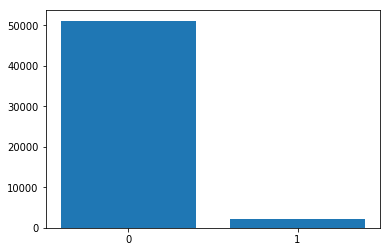

In [6]:
_ = plt.bar(Y_train.value_counts().index,Y_train.value_counts().values)
_ = plt.xticks(Y_train.value_counts().index)

In [7]:
Y_train.mean()

0.03933175480136806

We could find that most of Target variable is zero, only about 4% is 1.

### What about the characteristics of the features?

In [8]:
Char_feature = pd.DataFrame(columns = ['number of values','mean','mode','percentage of mode'])

In [9]:
for i in range(X_train.shape[1]):
    Char_feature.loc[i] = [X_train.iloc[:,i].value_counts().shape[0],\
                           X_train.iloc[:,i].mean(),X_train.iloc[:,i].value_counts().index[0],X_train.iloc[:,i].value_counts()[X_train.iloc[:,i].value_counts().index[0]]/X_train.shape[0]]
    X_train.iloc[:,i].value_counts()

In [10]:
Char_feature.head()

,number of values,mean,mode,percentage of mode
0,176.0,-1519.460518,2.0,0.975721
1,99.0,33.190269,23.0,0.265983
2,472.0,91.607295,0.0,0.952005
3,5550.0,71.772269,0.0,0.868738
4,6651.0,118.353445,0.0,0.845266


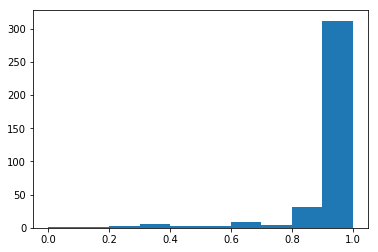

In [11]:
_ = plt.hist(Char_feature['percentage of mode'])

We could find that for most features, the mode value takes a lot of percentage.

In [12]:
(Char_feature['mode']==0).mean()

0.9378378378378378

And we could find that for most of the features, the mode values is zero.

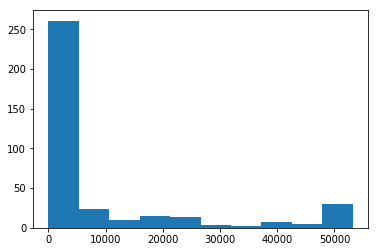

In [13]:
_ = plt.hist(kurtosis(X_train))

We coould find that the kurtosis of some features is really high, indicating there are some extremw values.

### Which of the features are numeric and which of them are discrete / possibly categorical?

In [14]:
feature = X_train.columns

In [15]:
invalid_feature = []#with zero or one value, which is meaning less to study
numeric_feature = []
categorical_feature = []
for i in feature:
    if X_train.loc[:,i].value_counts().shape[0] == 1 or X_train.loc[:,i].value_counts().shape[0] == 0:
        invalid_feature.append(i)
        # if there is zero or only one value of a feature, the feature is invalid.
    elif True in (X_train[i]<0).values:# if there is nageative values, it should be numeric
        numeric_feature.append(i)
    elif False in (((X_train[i]-X_train[i].apply(int))==0).values):
        numeric_feature.append(i)
        #if there is decimal value, it should be numeric
    elif X_train[i].value_counts().shape[0]==2 and X_train[i].max()<=4:
        categorical_feature.append(i)
        #if there are only two values, and the max is less than 3, it would be categorical
    elif False not in ((X_train[i].value_counts().index%3).values==0):
        numeric_feature.append(i)
        # a specific type of feature I guess should be numeric
    elif X_train[i].value_counts().shape[0]>20 or X_train[i].value_counts().shape[0]*10 < X_train[i].max():
        numeric_feature.append(i)
        # if there is a very big value or so many values, it should be numeric
    elif X_train[i].value_counts().shape[0]<10 and X_train[i].value_counts().shape[0]*2 >= X_train[i].max():
        categorical_feature.append(i)
        # if the number of different values is less than 10 and not a very big value, it should be categorical

In [16]:
len(invalid_feature)

46

There are 46 invalid features

In [17]:
len(numeric_feature)

225

There are 225 numeric features

In [18]:
len(categorical_feature)

99

There are 99 categorical feature

### Which features are related?

In [19]:
X_train_corr = X_train[numeric_feature + categorical_feature].corr()
X_train_corr_copy = X_train_corr.copy()
for i in range(X_train_corr_copy.shape[0]):
    for j in range(i,X_train_corr_copy.shape[0]):
        X_train_corr_copy.iloc[i,j] = 0

In [20]:
X_train_corr_copy.stack().apply(abs).sort_values(ascending=False)[:200]

var_258  var_1      1.000000
var_259  var_1      1.000000
var_267  var_128    1.000000
         var_130    1.000000
var_264  var_130    1.000000
                      ...   
var_238  var_241    0.977719
var_358  var_343    0.977530
var_312  var_351    0.977442
var_311  var_351    0.977183
         var_32     0.976273
Length: 200, dtype: float64

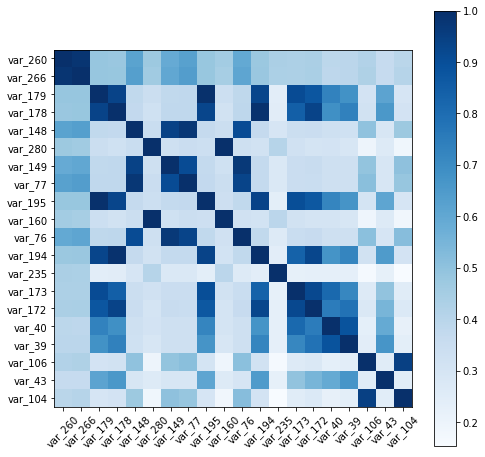

In [21]:
X_train_corr_copy = X_train_corr.copy().apply(abs)
cor_index = X_train_corr_copy.mean().sort_values(ascending=False)[:20].index

_ = plt.figure(figsize=(8, 8))
_ = plt.imshow(X_train_corr_copy.loc[cor_index,cor_index],cmap=plt.cm.Blues)
_ = plt.yticks(np.arange(20),cor_index.values)
_ = plt.xticks(np.arange(20),cor_index.values,rotation = 45)
_ = plt.colorbar()

The above graph shows the correlation between 20 features with highest average absolute correlation

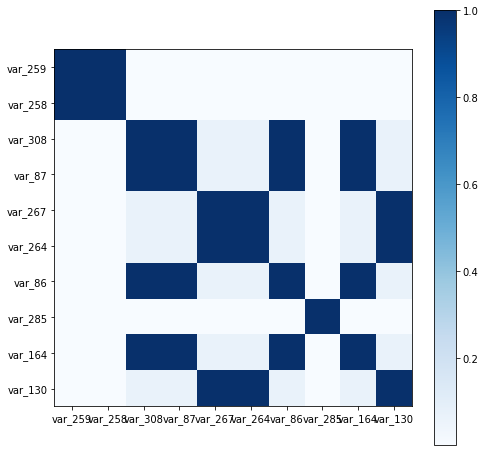

In [22]:
cor_index = X_train_corr_copy.stack().apply(abs).sort_values(ascending=False)[:200]\
    .index.to_frame().reset_index(drop=True).stack().value_counts().index[:10]

_ = plt.figure(figsize=(8, 8))
_ = plt.imshow(X_train_corr_copy.loc[cor_index,cor_index],cmap=plt.cm.Blues)
_ = plt.yticks(np.arange(10),cor_index.values)
_ = plt.xticks(np.arange(10),cor_index.values)
_ = plt.colorbar()

The above graph shows the correlation between 10 features with highest relation with one of other features. We could find that some of them is highly correlated with others.

## Preprocess the data

For categorical features, we need to change them into indicator variables
For numerical features, we need to nornalize them and put them in to sigmoid to deal with extrem values and protect the linearility of normal values.

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [25]:
class SigmoidScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X):
        return self
    def transform(self, X):
        return sigmoid(X)

In [26]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_feature)),
        ('std_scaler', StandardScaler()),
        ('sigmoid_scaler', SigmoidScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_feature)),
        ('label_binarizer', OneHotEncoder(handle_unknown = 'ignore',sparse = False)),
    ])

In [27]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [28]:
X_train_processed = full_pipeline.fit_transform(X_train)

In [29]:
X_train_processed.shape

(53214, 448)

### Fit a few classification models 

In [30]:
alpha_parameter = [0.00001,0.00005,0.0001,0.0005,0.001]
parameters = { 'alpha':alpha_parameter}
SGD_l1 = SGDClassifier(penalty='l1',loss='log',random_state=160)
clf_SGD_l1 = GridSearchCV(SGD_l1, parameters, cv=5,scoring="f1")
clf_SGD_l1.fit(X_train_processed, Y_train)
f1_score(Y_train,clf_SGD_l1.predict(full_pipeline.transform(X_train)))

0.22911741528762805

In [31]:
filename = 'optimal_l1.pkl'
pickle.dump(clf_SGD_l1, open(filename, 'wb'))

In [32]:
SGD_l2 = SGDClassifier(penalty='l2',loss='log',random_state=300)
clf_SGD_l2 = GridSearchCV(SGD_l2, parameters, cv=5,scoring="f1")
clf_SGD_l2.fit(X_train_processed, Y_train)
f1_score(Y_train,clf_SGD_l2.predict(full_pipeline.transform(X_train)))

0.21291150064129974

In [33]:
filename = 'optimal_l2.pkl'
pickle.dump(clf_SGD_l2, open(filename, 'wb'))

In [34]:
l1_ratio_parameter = [0.1,0.13,0.15,0.17,0.2]
elasticnet_parameters = { 'alpha':alpha_parameter,'l1_ratio':l1_ratio_parameter}
SGD_elasticnet = SGDClassifier(penalty='elasticnet',loss='log',random_state=160)
clf_SGD_elasticnet = GridSearchCV(SGD_elasticnet, elasticnet_parameters, cv=5,scoring="f1")
clf_SGD_elasticnet.fit(X_train_processed, Y_train)
f1_score(Y_train,clf_SGD_elasticnet.predict(full_pipeline.transform(X_train)))

0.10707737440410708

In [35]:
filename = 'optimal_elasticnet.pkl'
pickle.dump(clf_SGD_elasticnet, open(filename, 'wb'))

### Is F1 score the appropriate metric?

Yes, I guess it should be. F1 score is useful for imbalanced  dataset. But sometimes it does not converge.

### Plot the ROC curve

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

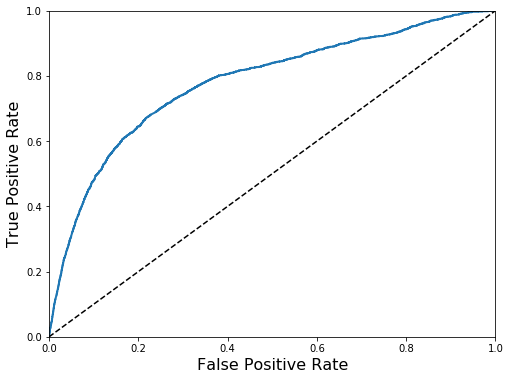

In [37]:
y_scores_l1 = clf_SGD_l1.decision_function(X_train_processed)
fpr_l1, tpr_l1, thresholds_l1 = roc_curve(Y_train, y_scores_l1 )
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_l1, tpr_l1)
plt.show()

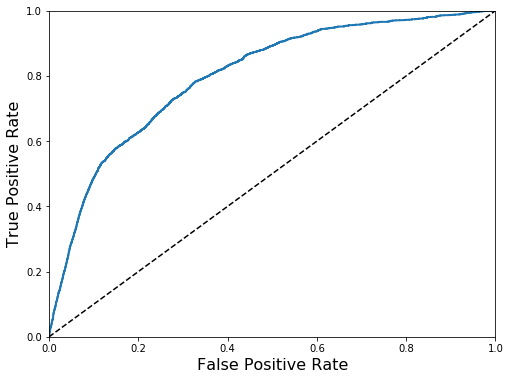

In [38]:
y_scores_l2 = clf_SGD_l2.decision_function(X_train_processed)
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(Y_train, y_scores_l2 )
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_l2, tpr_l2)
plt.show()

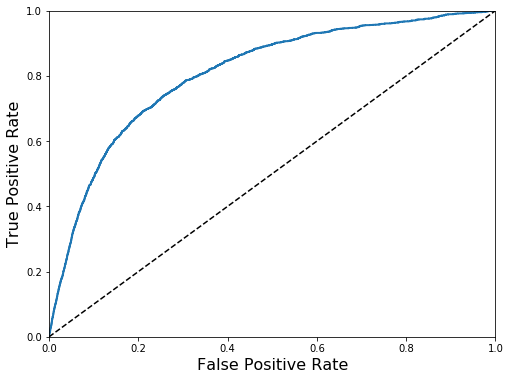

In [39]:
y_scores_elasticnet = clf_SGD_elasticnet.decision_function(X_train_processed)
fpr_elasticnet, tpr_elasticnet, thresholds_elasticnet = roc_curve(Y_train, y_scores_elasticnet )
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_elasticnet, tpr_elasticnet)
plt.show()

### Plot Precision-Recall curve

In [40]:
def plot_prc_curve(rec, pre, label=None):
    plt.plot(rec, pre, linewidth=2, label=label)
    plt.plot([1, 0], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)

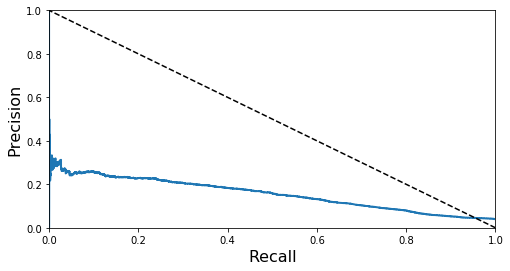

In [41]:
pre_l1, rec_l1, thresholds_l1 = precision_recall_curve(Y_train, y_scores_l1 )
plt.figure(figsize=(8, 4))
plot_prc_curve(rec_l1,pre_l1)
plt.show()

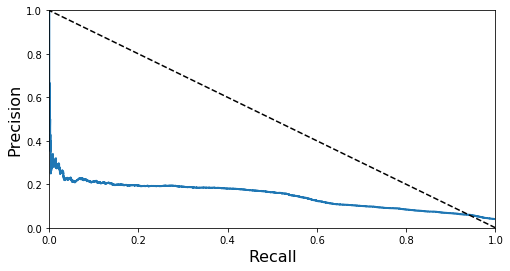

In [42]:
pre_l2, rec_l2, thresholds_l2 = precision_recall_curve(Y_train, y_scores_l2 )
plt.figure(figsize=(8, 4))
plot_prc_curve(rec_l2,pre_l2)
plt.show()

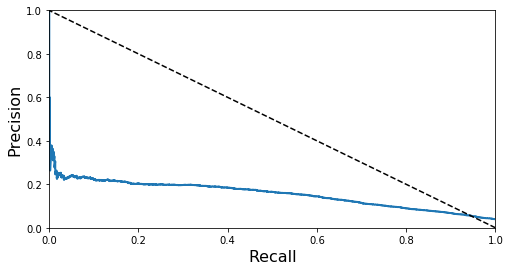

In [43]:
pre_elasticnet, rec_elasticnet, thresholds_elasticnet = precision_recall_curve(Y_train, y_scores_elasticnet )
plt.figure(figsize=(8, 4))
plot_prc_curve(rec_elasticnet,pre_elasticnet)
plt.show()

### How would the ROC / PR curves look differently if you used suboptimal model parameters?

if we used suboptimal model parameters, ROC curve will be less concave and lie between the ROC with best parameters and the dash line.

if we used suboptimal model parameters, PR curve will be less convex and lie between the PR curve with best parameters and the dash line.

## Extra credit 1

In [44]:
loss_parameter = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
penalty_parameter = ['l2','l1','elasticnet']
class_weight_parameter = [None,'balanced']
alpha_parameter = [0.00001,0.00005,0.0001,0.0005,0.001]
extra_parameters = { 'alpha':alpha_parameter,'loss':loss_parameter,'penalty':penalty_parameter,
                    'class_weight':class_weight_parameter}

In [45]:
SGD_extra = SGDClassifier(random_state=1)
clf_SGD_extra = GridSearchCV(SGD_extra, extra_parameters, cv=3,scoring="f1",verbose=2)
clf_SGD_extra.fit(X_train_processed, Y_train)
f1_score(Y_train,clf_SGD_extra.predict(X_train_processed))

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l2 ..........
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l2 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l2 ..........
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l1 ..........
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l1 ..........
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=l1 ..........
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=elasticnet ..
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=elasticnet, total=   0.5s
[CV] alpha=1e-05, class_weight=None, loss=hinge, penalty=elasticnet ..
[CV]  alpha=1e-05, class_weight=None, loss=hinge, penalty=elasticnet, total=   0.5s
[CV] alpha=1e-05, class_we

[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l2, total=   0.4s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=l2 ........
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l2, total=   0.4s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=l2 ........
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l2, total=   0.3s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=l1 ........
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l1, total=   0.6s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=l1 ........
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l1, total=   0.7s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=l1 ........
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=l1, total=   0.6s
[CV] alpha=1e-05, class_weight=balanced, loss=log, penalty=elasticnet 
[CV]  alpha=1e-05, class_weight=balanced, loss=log, penalty=elasticnet, total=   0.7s
[CV] alpha=1e-05, cl

[CV]  alpha=5e-05, class_weight=None, loss=log, penalty=elasticnet, total=   0.6s
[CV] alpha=5e-05, class_weight=None, loss=log, penalty=elasticnet ....
[CV]  alpha=5e-05, class_weight=None, loss=log, penalty=elasticnet, total=   0.6s
[CV] alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2 .
[CV]  alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2 .
[CV]  alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2 .
[CV]  alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l1 .
[CV]  alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l1, total=   0.5s
[CV] alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l1 .
[CV]  alpha=5e-05, class_weight=None, loss=modified_huber, penalty=l1,

[CV]  alpha=5e-05, class_weight=balanced, loss=modified_huber, penalty=elasticnet, total=   0.6s
[CV] alpha=5e-05, class_weight=balanced, loss=modified_huber, penalty=elasticnet 
[CV]  alpha=5e-05, class_weight=balanced, loss=modified_huber, penalty=elasticnet, total=   0.6s
[CV] alpha=5e-05, class_weight=balanced, loss=modified_huber, penalty=elasticnet 
[CV]  alpha=5e-05, class_weight=balanced, loss=modified_huber, penalty=elasticnet, total=   0.6s
[CV] alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2 
[CV]  alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2 
[CV]  alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2 
[CV]  alpha=5e-05, class_weight=balanced, loss=squared_hinge, penalty=l2, total=   0.2s
[CV] alpha=5e-05, class_weight=balanced, loss=squared_hinge, p

[CV]  alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=l1, total=   0.5s
[CV] alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=l1 .
[CV]  alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=l1, total=   0.5s
[CV] alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet 
[CV]  alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet, total=   0.5s
[CV] alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet 
[CV]  alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet, total=   0.5s
[CV] alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet 
[CV]  alpha=0.0001, class_weight=None, loss=squared_hinge, penalty=elasticnet, total=   0.6s
[CV] alpha=0.0001, class_weight=None, loss=perceptron, penalty=l2 ....
[CV]  alpha=0.0001, class_weight=None, loss=perceptron, penalty=l2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, loss=perceptron, penalty=l2 ....
[CV]  alpha=0.0001, cl

[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l2, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l2 
[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l2, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1 
[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1, total=   0.5s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1 
[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1, total=   0.5s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1 
[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=l1, total=   0.5s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=elasticnet 
[CV]  alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=elasticnet, total=   0.6s
[CV] alpha=0.0001, class_weight=balanced, loss=perceptron, penalty=elasticnet 
[CV]  alpha=0.0001, class_weight=b

[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l2 .....
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l2 .....
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l2, total=   0.2s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1 .....
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1 .....
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1 .....
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=l1, total=   0.5s
[CV] alpha=0.0005, class_weight=balanced, loss=hinge, penalty=elasticnet 
[CV]  alpha=0.0005, class_weight=balanced, loss=hinge, penalty=elasticnet, total=   0

[CV]  alpha=0.001, class_weight=None, loss=hinge, penalty=elasticnet, total=   0.4s
[CV] alpha=0.001, class_weight=None, loss=hinge, penalty=elasticnet ..
[CV]  alpha=0.001, class_weight=None, loss=hinge, penalty=elasticnet, total=   0.4s
[CV] alpha=0.001, class_weight=None, loss=log, penalty=l2 ............
[CV]  alpha=0.001, class_weight=None, loss=log, penalty=l2, total=   0.3s
[CV] alpha=0.001, class_weight=None, loss=log, penalty=l2 ............
[CV]  alpha=0.001, class_weight=None, loss=log, penalty=l2, total=   0.3s
[CV] alpha=0.001, class_weight=None, loss=log, penalty=l2 ............
[CV]  alpha=0.001, class_weight=None, loss=log, penalty=l2, total=   0.3s
[CV] alpha=0.001, class_weight=None, loss=log, penalty=l1 ............
[CV]  alpha=0.001, class_weight=None, loss=log, penalty=l1, total=   0.6s
[CV] alpha=0.001, class_weight=None, loss=log, penalty=l1 ............
[CV]  alpha=0.001, class_weight=None, loss=log, penalty=l1, total=   0.6s
[CV] alpha=0.001, class_weight=None,

[CV]  alpha=0.001, class_weight=balanced, loss=log, penalty=elasticnet, total=   0.6s
[CV] alpha=0.001, class_weight=balanced, loss=log, penalty=elasticnet 
[CV]  alpha=0.001, class_weight=balanced, loss=log, penalty=elasticnet, total=   0.6s
[CV] alpha=0.001, class_weight=balanced, loss=log, penalty=elasticnet 
[CV]  alpha=0.001, class_weight=balanced, loss=log, penalty=elasticnet, total=   0.6s
[CV] alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2 
[CV]  alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2 
[CV]  alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2 
[CV]  alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, loss=modified_huber, penalty=l1 
[CV]  alpha=0.001, class_weight=balan

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  4.3min finished


0.21954161640530762

In [46]:
RF = RandomForestClassifier(random_state=0)
criterion_parameters = ['gini','entropy']
max_depth_parameters = [5,5,10,12,15]
min_samples_split_parameterst = [2,5,10,15,20]
min_samples_leaf_parameters = [1,3,5,7,9]
class_weigh_parameterst = ['balanced','balanced_subsample','None']

In [47]:
RF_parameters = { 'criterion':criterion_parameters,'max_depth':max_depth_parameters,
                 'min_samples_split':min_samples_split_parameterst,
                 'min_samples_leaf':min_samples_leaf_parameters,
                 'class_weight':class_weight_parameter}

In [48]:
clf_RF = GridSearchCV(RF, RF_parameters, cv=3,scoring="f1",verbose=2)

In [49]:
clf_RF.fit(X_train_processed, Y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_sa

[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, m

[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=

[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.6s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.5s
[CV] class_weight=None, criterion=gini, max_depth=5, min_samples_leaf=7, 

[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2, total=   0.8s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=5, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_lea

[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=20, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=20, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=10, min_sam

[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=5, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=5, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=12, min_sample

[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=20, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=12, min_samples_leaf=9, min_samples_split=5, total=   0.9s
[CV] class_weight=None, criterion=gini, max_depth=12, min_samples_lea

[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.1s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=20, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=20 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=20, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_sam

[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10 
[CV]  class_weight=None, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=10, total=   1.0s
[CV] class_weight=None, criterion=gini, max_depth=15, min_sample

[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_dept

[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.6s
[CV] class_weight=None, criterion=entropy, 

[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=2, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_dep

[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.5s
[CV] class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.6s
[CV] class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2, total=   0.8s
[CV] class_weight=None, criterion=entropy, 

[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10 
[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, total=   0.8s
[CV] class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10 
[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10 
[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=15, total=   0.8s
[CV] class_weight=None, criterion=e

[CV]  class_weight=None, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=20, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=1, min_samples_split=5, total=   1.0s
[CV] class_weight=None, criterion=entropy,

[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=10, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15, total=   0.9s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=15, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=20, total=   1.0s
[CV] class_weight=None, criterion=

[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=2, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=5, total=   1.2s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=10 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=1, min_samples_split=10, total=   1.1s
[CV] class_weight=None, criterion=entropy

[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=15, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20, total=   1.2s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20, total=   1.0s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=5, min_samples_split=20, total=   1.1s
[CV] class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=None, criterion=entropy, max_depth=15, min_samples_leaf=7, min_samples_split=2, total=   1.0s
[CV] class_weight=None, criterion=en

[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, total=   0.6s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.6s
[CV] class_weight=balanced, criteri

[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.5s
[CV] class_weight=balanced, criterion=gini

[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=15, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=20, total=   0.5s
[CV] class_weight=balanced, criter

[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.5s
[CV] class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=gin

[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=15, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=20, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=3, min_samples_split=2, total=   0.8s
[CV] class_weight=balanced,

[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=5, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=15, total=   0.8s
[CV] class_weight=balanced

[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=1, min_samples_split=20, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=5, total=   0.9s
[CV] class_weight=balanced, crite

[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=10, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=15, total=   0.9s
[CV] class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=20, total=   0.9s
[CV] class_weight=balance

[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=2, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=5, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=3, min_samples_split=10, total=   1.0s
[CV] class_weight=balanced, crit

[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=15, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=7, min_samples_split=20, total=   1.0s
[CV] class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced,

[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=5, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=5, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.5s
[CV] class

[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2, total=   0.6s
[CV] class_

[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=5, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.5s
[CV] cla

[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=5, min_samples_leaf=9, min_samples_split=2, total=   0.5s
[CV] class_we

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=15, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=15, total=   0.9

[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=7, min_samples_split=20, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=2, total=   0.8s
[CV] class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=9, min_samples_split=5, total=   0.8s
[CV] c

[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=10, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=10 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=10, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=3, min_samples_split=15, total=   0.9

[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=2, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=12, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] cl

[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=10, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=15, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=20 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=3, min_samples_split=20, total=   1.0

[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=2, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=2 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=2, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5 
[CV]  class_weight=balanced, criterion=entropy, max_depth=15, min_samples_leaf=9, min_samples_split=5, total=   1.0s
[CV] cl

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 25.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 5, 10, 12, 15], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 3, 5, 7, 9], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [50]:
f1_score(Y_train,clf_RF.predict(X_train_processed))

0.27466820542411996

## Finally use the test set

In [51]:
X_test_processed = full_pipeline.transform(X_test)

In [52]:
f1_score(Y_test,clf_SGD_l1.predict(X_test_processed))

0.21150278293135438

In [53]:
f1_score(Y_test,clf_SGD_l2.predict(X_test_processed))

0.20497512437810944

In [54]:
f1_score(Y_test,clf_SGD_elasticnet.predict(X_test_processed))

0.10109519797809603

In [55]:
f1_score(Y_test,clf_SGD_extra.predict(X_test_processed))

0.19738406658739593

In [56]:
f1_score(Y_test,clf_RF.predict(X_test_processed))

0.20739260739260743

In [57]:
clf_SGD_l1.best_estimator_

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=160, shuffle=True,
       tol=None, verbose=0, warm_start=False)

clf_SGD_l1,which is logistic regression with l1 regularization with alpha=1e-05 and  class_weight=None is the best set. Theoratically, clf_SGD_extra should perform better, but as SGD sometimes does not converge, sometimes the result is high dependent on the random seed.

In [58]:
filename = 'best_model.pkl'
pickle.dump(clf_SGD_l1, open(filename, 'wb'))

I am not sure whether index should be excluded or not. I do not exclude it because if does not have information, model will tell it.
And I am not sure whether the pickle should include the pipline or not. I did not do that. So please use the pipline to deal with data before you use data to test my model.